In [1]:
from collections import defaultdict
from matplotlib import pyplot as plt
from typing import Optional

import os
import re
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
path = "../data/ukraine/"

In [2]:
df = pd.DataFrame()

for filename in os.listdir(path):
    if filename[-5:] == ".gzip":
        temp = pd.read_csv(
            path + filename, 
            compression="gzip",
            index_col=0
        )
        df = pd.concat([ df, temp ])

C:\Users\Flo\AppData\Local\Temp\ipykernel_14008\942500209.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(
C:\Users\Flo\AppData\Local\Temp\ipykernel_14008\942500209.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(
C:\Users\Flo\AppData\Local\Temp\ipykernel_14008\942500209.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(
C:\Users\Flo\AppData\Local\Temp\ipykernel_14008\942500209.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(
C:\Users\Flo\AppData\Local\Temp\ipykernel_14008\942500209.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(


In [3]:
df.to_csv(path + "UkraineCombinedTweetsDeduped.csv.gzip",
          compression= "gzip")

In [3]:
df = pd.read_csv(
    path + "UkraineCombinedTweetsDeduped.csv.gzip",
    compression= "gzip",
    index_col=0
)

C:\Users\Flo\AppData\Local\Temp\ipykernel_14460\1015441068.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [4]:
df_users = df[[
    'userid', 'username', 'acctdesc', 'location', 'following',
    'followers', 'totaltweets', 'usercreatedts'
]]
df_users = df_users.drop_duplicates(subset=['userid'])
print(df_users.shape)
df_users.head()

(1777018, 8)


,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts
0,962369743,toonspt_,พยรลก 😉\nจะเปิดแอคเมื่อขายของเท่านั้น!!,NaN,462,7,20549,2012-11-21 13:01:19.000000
1,865846412755353600,SabrinaBbsmith,อ้ายคือปริญญาใจน้องจึงยิ้มได้วันนี้ #สมรสเท่าเ...,Just go for it,385,503,84016,2017-05-20 08:27:26.000000
2,1927022036,haleggwenn,"Mathe & Kulturanthropologie • Feminismus, Anti...","Göttingen, Germany",251,51,78,2013-10-02 14:19:01.000000
3,1073676020,IndiaTodayFLASH,No dragging feet on news. Crisp & short news s...,NaN,117,1152610,589066,2013-01-09 12:46:38.000000
4,1484119658488033281,sandsand_fight,NaN,NaN,128,3,691,2022-01-20 11:05:01.000000


In [5]:
df_tweets = df[[
    'userid',
    'tweetid', 'tweetcreatedts', 'retweetcount', 'text',
    'hashtags', 'language', 'favorite_count',
    # 'coordinates', 'extractedts'
]]
df_tweets = df_tweets.drop_duplicates(subset=['text'])
df_tweets['hashtags'] = df_tweets['hashtags'].apply(
    lambda string: re.findall(r"(?<=[\"\']text[\"\']: [\"\'])\w+(?=[\"\'],)", string)
)
print(df_tweets.shape)
df_tweets.head()

(1460910, 8)


,userid,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,favorite_count
0,962369743,1496738675085897729,2022-02-24 06:48:02.000000,1897,Footage of the airport bombing in Ivano-Franki...,"[Ukraine, Russia]",en,0
1,865846412755353600,1496738675140538368,2022-02-24 06:48:02.000000,3534,12.37 น. เจมส์ วอเตอร์เฮาส์ ผู้สื่อข่าว BBC ใน...,[],th,0
2,1927022036,1496738675522248706,2022-02-24 06:48:02.000000,0,"Die Rede von #Putin ist echt gruselig:\n""Russl...","[Putin, Ukraine]",de,0
3,1073676020,1496738675584954371,2022-02-24 06:48:02.000000,18,Ukraine MP Sophia Fedyna tells about the groun...,[ITVideo],en,0
4,1484119658488033281,1496738675710857224,2022-02-24 06:48:03.000000,3974,รัสเซียยิงขีปนาวุธรัวๆไปยังยูเครน\n#รัสเซียยูเ...,"[RussiaUkraine, UkraineRussiaCrisis]",th,0


# Basic exploration

In [6]:
def explore(df: pd.DataFrame, col: str, continuous: bool = True, index: str = ""):
    """ Shows basic stats and plots histogram / bar plot """
    s = df[col] if continuous else df[col].value_counts()
    print(s.describe())
    
    if continuous:
        s.hist(log=True, bins=20)
    else:
        if index:
            s.index = [
                df[df[col] == idx][index].iloc[0]
                for idx in s.index
            ]
        s[:20].plot.bar(log=True)
    plt.show()
    
    
def build_cat(s: pd.Series, lims: list):
    """ Builds categories according to limits """
    lims.sort()
    
    def get_cat(x):
        for i, lim in enumerate(lims):
            if x < lim:
                return i
        return len(lims)
    
    s_cat = s.apply(get_cat)
    print(s_cat.value_counts())
    return s_cat

In [7]:
def plot_timestamps(s: pd.Series):
    """ Plot timestamp data (per day) """
    s_count = s.apply(
        lambda date: date.split()[0]
    ).value_counts()
    s_count = s_count.sort_index()
    print(s_count)
    s_count.plot.line()
    plt.show()

## df_users

### totaltweets

count    1.777018e+06
mean     2.434179e+04
std      6.202917e+04
min      0.000000e+00
25%      6.240000e+02
50%      4.410000e+03
75%      2.023100e+04
max      4.238289e+06
Name: totaltweets, dtype: float64


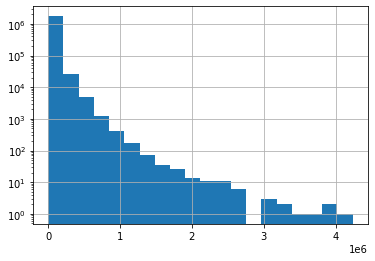

In [8]:
explore(df_users, 'totaltweets', continuous=True)

In [9]:
lims = [ 2850000, 3700000 ]
df_users['totaltweets_cat'] = build_cat(df_users['totaltweets'], lims)

0    1777008
1          7
2          3
Name: totaltweets, dtype: int64


### following

count    1.777018e+06
mean     1.047519e+03
std      4.233490e+03
min      0.000000e+00
25%      1.170000e+02
50%      3.650000e+02
75%      1.008000e+03
max      1.422324e+06
Name: following, dtype: float64


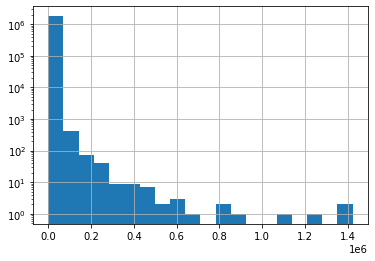

In [10]:
explore(df_users, 'following', continuous=True)

In [11]:
lims = [ 500000, 1000000 ]
df_users['following_cat'] = build_cat(df_users['following'], lims)

0    1777005
1          9
2          4
Name: following, dtype: int64


### followers

count    1.777018e+06
mean     2.922749e+03
std      9.315339e+04
min      0.000000e+00
25%      3.100000e+01
50%      1.650000e+02
75%      6.940000e+02
max      5.201331e+07
Name: followers, dtype: float64


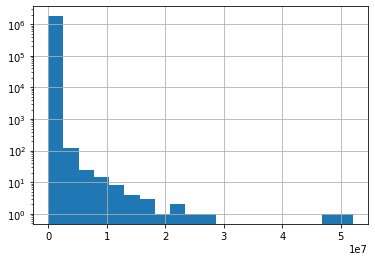

In [12]:
explore(df_users, 'followers', continuous=True)

In [13]:
lims = [ 11500000, 15000000 ]
df_users['followers_cat'] = build_cat(df_users['followers'], lims)

0    1776999
2         10
1          9
Name: followers, dtype: int64


### location

count    335650.000000
mean          3.052927
std          49.514377
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       11139.000000
Name: location, dtype: float64


c:\users\flo\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\flo\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\flo\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3632 (\N{THAI CHARACTER SARA A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\flo\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\flo\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3607 (\N{THAI CHARACTER THO THAHAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\flo\minicond

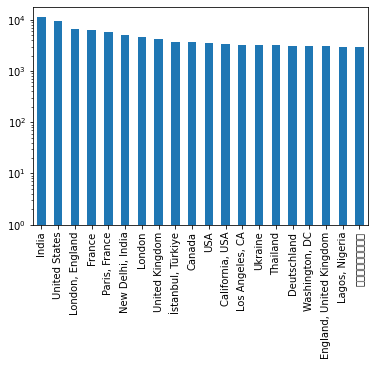

In [14]:
explore(df_users, 'location', continuous=False)

### usercreatedts

1970-01-01       3
2006-05-01       1
2006-07-13       1
2006-07-14       3
2006-07-15       1
              ... 
2022-03-02    2900
2022-03-03    2692
2022-03-04    6227
2022-03-05    2761
2022-03-06    2590
Name: usercreatedts, Length: 5635, dtype: int64


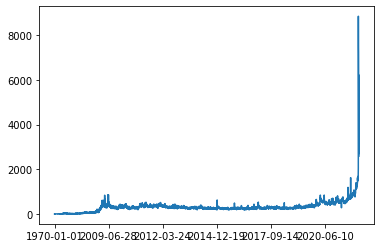

In [15]:
plot_timestamps(df_users['usercreatedts'])

## df_tweets

### tweetcreatedts

2022-02-24    107212
2022-02-25    128403
2022-02-26    126298
2022-02-27    113341
2022-02-28    126792
2022-03-01    131618
2022-03-02    132418
2022-03-03    126792
2022-03-04    151690
2022-03-05    162172
2022-03-06    154174
Name: tweetcreatedts, dtype: int64


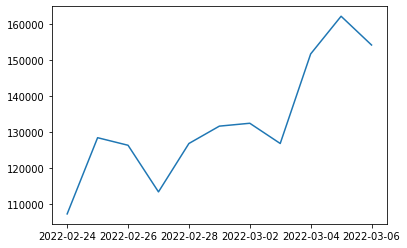

In [16]:
plot_timestamps(df_tweets['tweetcreatedts'])

### userid

count    636406.000000
mean          2.295563
std           7.230919
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1296.000000
Name: userid, dtype: float64


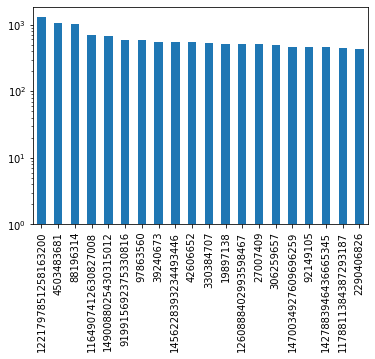

In [17]:
explore(df_tweets, 'userid', continuous=False)

### language

count        65.000000
mean      22475.538462
std      106323.446017
min           1.000000
25%         169.000000
50%        1152.000000
75%        6239.000000
max      849551.000000
Name: language, dtype: float64


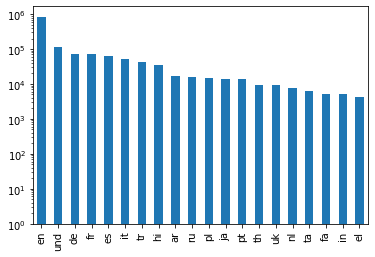

In [18]:
explore(df_tweets, 'language', continuous=False)

### favorite_count

count    1.460910e+06
mean     7.467216e-01
std      8.782940e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.271000e+04
Name: favorite_count, dtype: float64


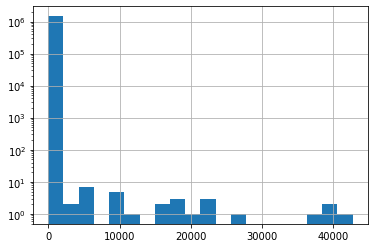

In [19]:
explore(df_tweets, 'favorite_count')

> It looks like a log(log) tendency ^^

In [20]:
lims = [ 750 ]
df_tweets['favorite_count_cat'] = build_cat(df_tweets['favorite_count'], lims)

0    1460838
1         72
Name: favorite_count, dtype: int64


### retweetcount

count    1.460910e+06
mean     6.424392e+00
std      1.713753e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      6.509300e+04
Name: retweetcount, dtype: float64


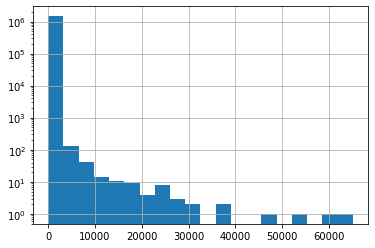

In [21]:
explore(df_tweets, 'retweetcount', continuous=True)

In [22]:
lims = [ 60000, 120000 ]
df_tweets['retweetcount_cat'] = build_cat(df_tweets['retweetcount'], lims)

0    1460909
1          1
Name: retweetcount, dtype: int64


## Scatter plots

In [23]:
def plot_scatter(x: str, y: str):
    """ Plots scatter plot """
    df.plot.scatter(x, y, logx=True, logy=True, alpha=.002)
    plt.show()

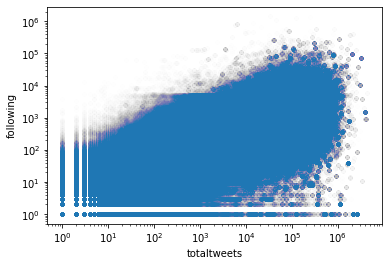

In [24]:
plot_scatter('totaltweets', 'following')

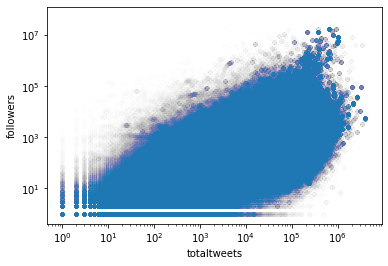

In [25]:
plot_scatter('totaltweets', 'followers')

> We can spot some points popping out from the general tendency

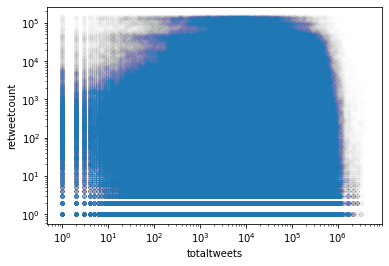

In [26]:
plot_scatter('totaltweets', 'retweetcount')

In [ ]:
df.plot.scatter(
    'totaltweets', 
    'followers',
    c='following_cat',
    colormap='jet',
    logx=True, 
    logy=True,
    alpha=.002
)
plt.show()


# Hashtags

In [27]:
counter = defaultdict(int)
for hashtags in df['hashtags']:
    for hashtag in hashtags:
        counter[hashtag] += 1
counter = pd.Series(counter)

count    4.109000e+03
mean     1.105146e+05
std      1.652251e+06
min      1.000000e+00
25%      2.000000e+00
50%      8.000000e+00
75%      5.300000e+01
max      6.073103e+07
dtype: float64


<AxesSubplot:>

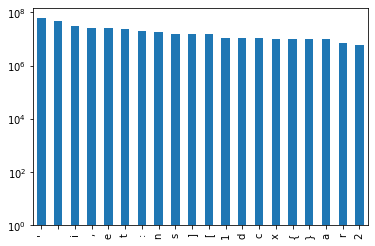

In [28]:
counter = counter.sort_values(ascending=False)
print(counter.describe())
counter.iloc[:20].plot.bar(log=True)

## Best hashtags

In [29]:
top = 100
best_ht = counter.iloc[:top]

In [30]:
ht_pair = pd.DataFrame(index=best_ht.index, columns=best_ht.index)
ht_pair = ht_pair.fillna(0)

for hashtags in df_tweets['hashtags']:
    hashtags = [ 
        ht for ht in hashtags
        if ht in best_ht.index
    ]
    
    if len(hashtags) > 1:
        for i, ht_1 in enumerate(hashtags):
            for ht_2 in hashtags[i+1:]:
                ht_pair.loc[ht_1, ht_2] += 1
                ht_pair.loc[ht_2, ht_1] += 1

for i in range(len(best_ht)):
    ht_pair.iloc[i, i] = 0
ht_pair.head()

,',,i,",",e,t,:,n,s,],...,к,в,ส,ี,ั,ซ,т,ب,ة,У
',0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
",",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e,0,0,0,0,0,10,0,11,1,0,...,0,0,0,0,0,0,0,0,0,0


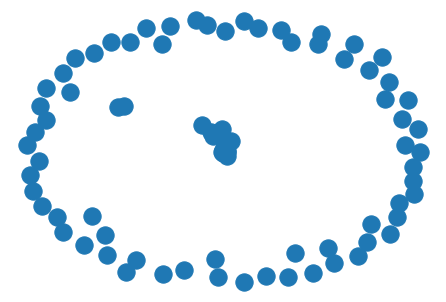

In [31]:
G = nx.from_pandas_adjacency(ht_pair)
nx.draw(G)